<a href="https://colab.research.google.com/github/shintafiaa/Teaching-Assistant-Technobar/blob/main/Technobar/6_XGBoost_data_melb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learn on how to build and optimize model with **gradient boosting.**

#Introduction
By definition, **ensemble methods** combine the predictions of several models (e.g., several trees, in the case of random forest).

Now, we'll learn about another ensemble method called gradient boosting.

#Difference of Decision Tree, Random Forest, and XGBoost

1. Decision Tree:
A decision tree is a simple and interpretable model that recursively splits the data into subsets based on the feature values. It forms a tree-like structure where each internal node represents a test on a feature, each branch represents the outcome of that test, and each leaf node represents the final prediction. The decision tree makes binary decisions at each node to split the data. It is prone to overfitting, especially when the tree becomes deep, capturing noise and leading to poor generalization on unseen data.

2. Random Forest:
Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions through voting (for classification) or averaging (for regression). Each decision tree is trained on a random subset of the data (bootstrap sample) and a random subset of the features. This randomness reduces overfitting and increases the model's ability to generalize to new data.

3. XGBoost (Extreme Gradient Boosting):
XGBoost is an optimized implementation of the Gradient Boosting algorithm. It creates an ensemble of weak learners (usually shallow decision trees) sequentially, where each new model corrects the errors made by the previous one. XGBoost uses a gradient-based optimization algorithm to minimize a loss function while adding new trees to the ensemble. It also includes regularization terms to control overfitting and speed up the training process. XGBoost is known for its high performance, scalability, and efficiency, making it popular in various machine learning competitions and real-world applications.
**XGBoost** is an implementation of gradient boosting with several additional features focused on perfmance and speed. The final result of an XGBoost model is a weighted sum of the predictions made by all the individual trees in the sequence. The contribution of each tree is adjusted during training based on how well it reduces the overall error.


Note:

* Regularization (penyederhanaan): XGBoost introduces regularization terms to control overfitting during the training process. Regularization helps prevent the model from becoming too complex and ensures better generalization to unseen data.


#Gradient Boosting

**Gradient boosting** is a method that goes through cycles to iteratively add models into an ensemble (setelan).

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent (kemudian) additions to the ensemble will address those errors.)

Then, we start the cycle:
1. First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we **add the predictions from all models** in the ensemble.
2. These predictions are used to calculate a loss function (like mean squared error, for instance).
3. Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss.
4. Finally, we add the new model to ensemble, and ...
5. Repeat!

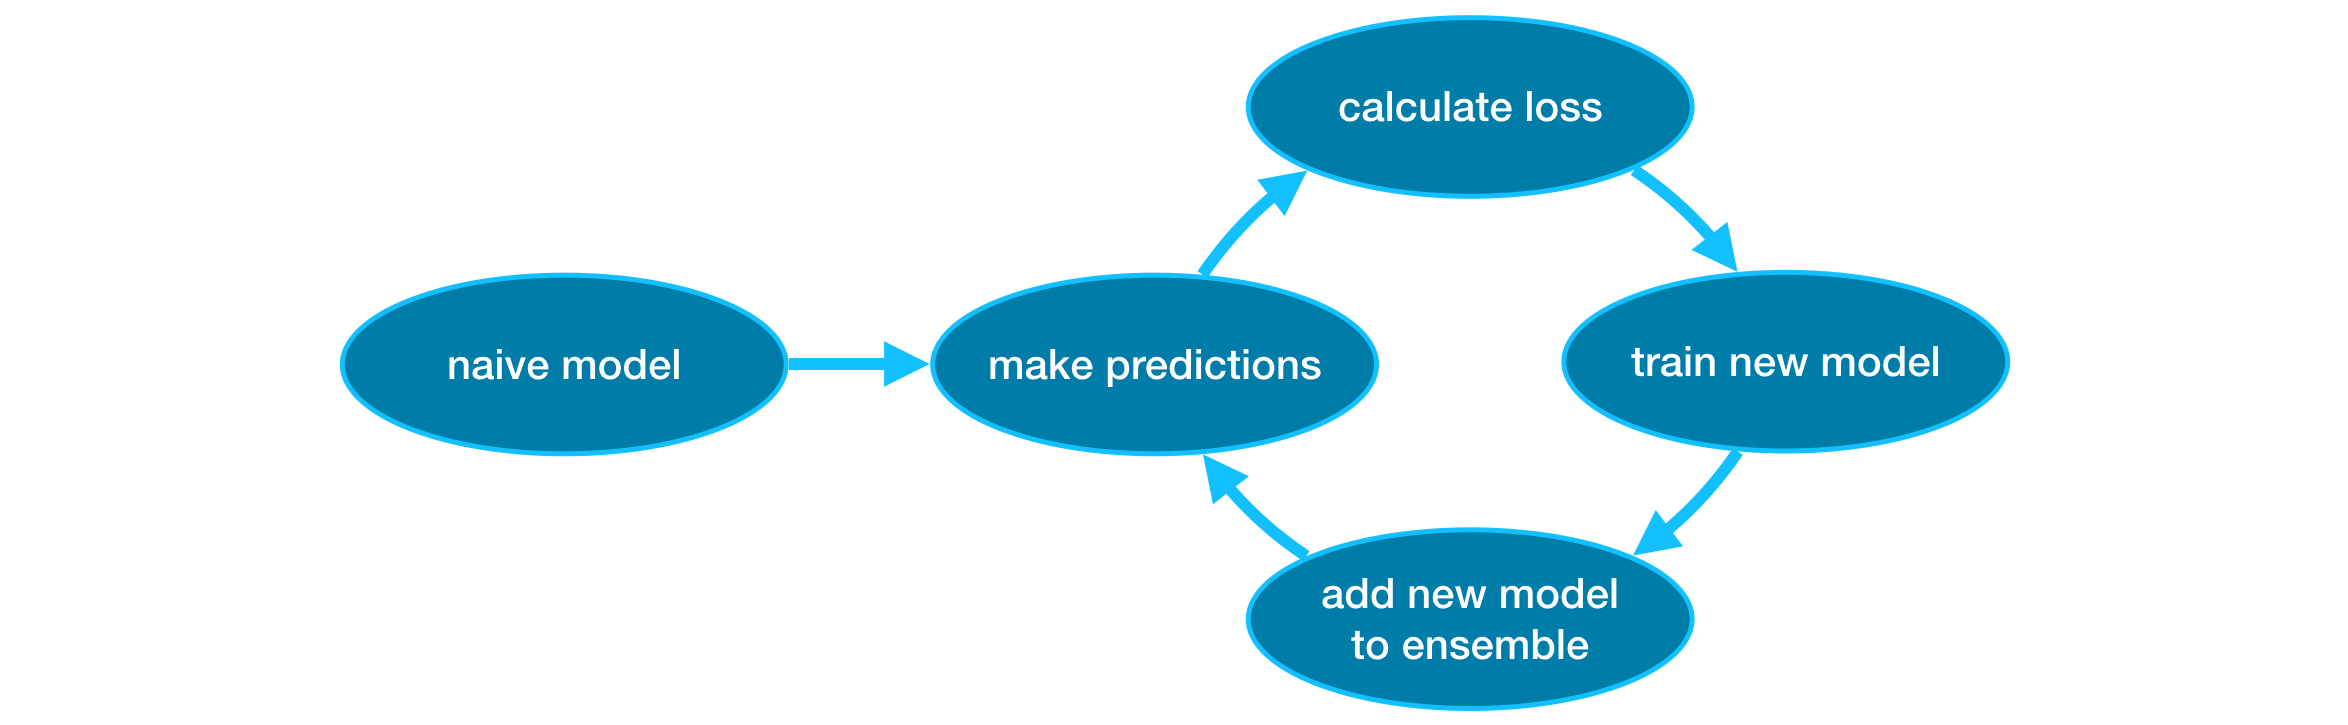

#Example
We begin by loading the training and validation data in X_train, X_valid, y_train, y_valid.

**Prompt:**

Write a code cell to mount Google Drive in Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Prompt:**

Write a code cell to read a CSV file from Google Drive into a DataFrame.

In [2]:
import pandas as pd
file_path = '/content/drive/MyDrive/Dataset/melb_data.csv'
data = pd.read_csv(file_path)

data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

**Prompt:**

Write a code cell to select a subset of predictors ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt'] and set the target variable ['Price'] from the DataFrame.

In [8]:
# prompt: Write a code cell to select a subset of predictors ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt'] and set the target variable ['Price'] from the DataFrame.

# Select the subset of predictors and target variable
predictors = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
target = 'Price'

X = data[predictors]
y = data[target]
print(X.head())
print(y.head())


   Rooms  Distance  Landsize  BuildingArea  YearBuilt
0      2       2.5     202.0           NaN        NaN
1      2       2.5     156.0          79.0     1900.0
2      3       2.5     134.0         150.0     1900.0
3      3       2.5      94.0           NaN        NaN
4      4       2.5     120.0         142.0     2014.0
0    1480000.0
1    1035000.0
2    1465000.0
3     850000.0
4    1600000.0
Name: Price, dtype: float64


**Prompt:**

Write a code cell to split the data into training and validation

In [9]:
# split the data into training and validation

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Display the shapes of the training and validation sets
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((10864, 5), (2716, 5), (10864,), (2716,))

In the next code cell, we import the scikit-learn API for XGBoost (`xgboost.XGBRegressor`). As you'll see in the output, the `XGBRegressor` class has many tunable parameters.


**Prompt:**

Write a code cell to train the model using XGBoost, and print the mean absolute error on the validation set.

In [10]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Create an XGBoost regressor
my_model = xgb.XGBRegressor(random_state=0)

# Fit the model to the training data
my_model.fit(X_train, y_train)

# Make predictions on the validation set
predictions = my_model.predict(X_valid)

# Calculate the mean absolute error
mae = mean_absolute_error(predictions, y_valid)

# Print the mean absolute error
print("Mean Absolute Error: " + str(mae))


Mean Absolute Error: 235734.8582991992


We also make predictions and evaluate the model.

#Parameter Tuning
XGBoost has a few parameters that can dramatically affect accuracy and training speed. The first parameters you should understand are:

`n_estimators`
Specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.
* Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
* Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

Typical values range from 100-1000, though this depends a lot on the `learning_rate` parameter discussed below.

Here is the code to set the number of models in the ensemble:

**Prompt:**

Write a code cell to create another XGBRegressor with 500 estimators, train it, and print the mean absolute error on the validation set.

In [11]:
# Create an XGBoost regressor with 500 estimators
my_model_2 = XGBRegressor(n_estimators=500, random_state=0)

# Fit the model to the training data
my_model_2.fit(X_train, y_train)

# Make predictions on the validation set
predictions_2 = my_model_2.predict(X_valid)

# Calculate the mean absolute error
mae_2 = mean_absolute_error(predictions_2, y_valid)

# Print the mean absolute error
print("Mean Absolute Error (500 estimators): " + str(mae_2))


Mean Absolute Error (500 estimators): 242472.02245446545


The MAE result of the model with n_estimators set to 500 turned out to be greater than the default value of n_estimators, which is 100.

The MAE (Mean Absolute Error) of the model with an n_estimators value of 110 turns out to be smaller than the default n_estimators value of 100, as well as n_estimators with a value of 500.

`early_stopping_rounds`
offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stop improving, even if we aren't the hard stop for `n_estimators`. It's smart to set a high value for `n_estimators` and then use `early_stopping_rounds` to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration (keburukan) to allow before stopping. Setting `early_stopping_rounds=5` is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores. This is done by setting the `eval_set` parameter.

We can modify the example above to include early stopping.

---
Note:

* In the context of training machine learning models, "deteriorating" refers to a situation where the performance of the model on a validation dataset worsens over consecutive iterations during the training process. Typically, we monitor a metric (such as accuracy, mean squared error, etc.) on the validation dataset to evaluate the model's performance.

* In the given code, verbose=False is an argument passed to the fit method of the XGBRegressor model. Setting verbose to False means that during the training process, the model will not produce any output or progress messages. It will train silently without displaying information about each boosting round.

**Prompt:**

Write a code cell to train an XGBRegressor with 110 estimators and early stopping rounds, and print the mean absolute error on the validation set.

In [12]:
# Create an XGBoost regressor with a custom learning rate, 90 estimators, and early stopping
my_model_3 = XGBRegressor(n_estimators=90, learning_rate=0.1, verbosity = 1, random_state=0, early_stopping_rounds=10)

# Fit the model to the training data with early stopping
my_model_3.fit(X_train, y_train,eval_set=[(X_valid, y_valid)],verbose = True)

# Make predictions on the validation set
predictions_3 = my_model_3.predict(X_valid)

# Calculate the mean absolute error
mae_3 = mean_absolute_error(predictions_3, y_valid)

# Print the mean absolute error
print("Mean Absolute Error (90 estimators, custom learning rate, early stopping): " + str(mae_3))


[0]	validation_0-rmse:597126.02308
[1]	validation_0-rmse:570453.22052
[2]	validation_0-rmse:546593.15392
[3]	validation_0-rmse:526666.23292
[4]	validation_0-rmse:508933.52388
[5]	validation_0-rmse:494336.00975
[6]	validation_0-rmse:480078.62122
[7]	validation_0-rmse:468005.94808
[8]	validation_0-rmse:459298.15612
[9]	validation_0-rmse:449789.37514
[10]	validation_0-rmse:442636.27385
[11]	validation_0-rmse:436276.23444
[12]	validation_0-rmse:430507.85794
[13]	validation_0-rmse:425501.97808
[14]	validation_0-rmse:421691.16701
[15]	validation_0-rmse:419540.54086
[16]	validation_0-rmse:415614.06569
[17]	validation_0-rmse:413196.66147
[18]	validation_0-rmse:411078.33794
[19]	validation_0-rmse:409265.64150
[20]	validation_0-rmse:407123.65206
[21]	validation_0-rmse:405570.94794
[22]	validation_0-rmse:404147.67946
[23]	validation_0-rmse:402117.63730
[24]	validation_0-rmse:400903.78250
[25]	validation_0-rmse:399530.64278
[26]	validation_0-rmse:398959.71823
[27]	validation_0-rmse:397838.53412
[2

`n_jobs`

On larger datasets where runtime is a consideration, you can use parallelism to build your model faster. It's common to set the parameter `n_jobs` equal to the number of cores on your machine. On smaller datasets, this won't help.
The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the `fit` command.

Here's the modified example.

**Prompt:**

Write a code cell to train an XGBRegressor with a custom learning rate, 90 estimators, and early stopping rounds, and print the mean absolute error on the validation set.

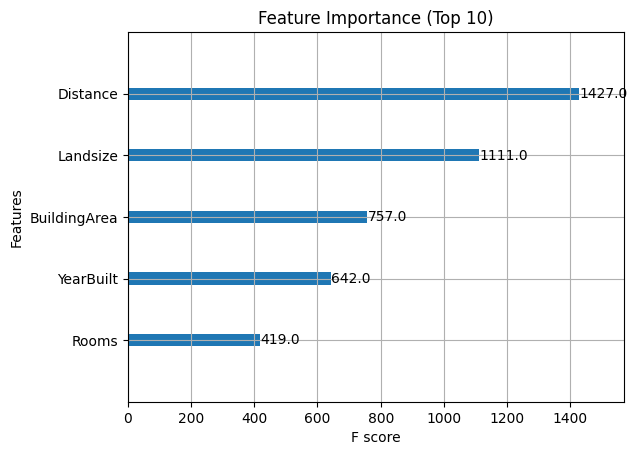

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance # Import the plot_importance function

# Plot feature importance
plot_importance(my_model_3, importance_type='weight', max_num_features=10)
plt.title("Feature Importance (Top 10)")
plt.show()

<Figure size 2000x1000 with 0 Axes>

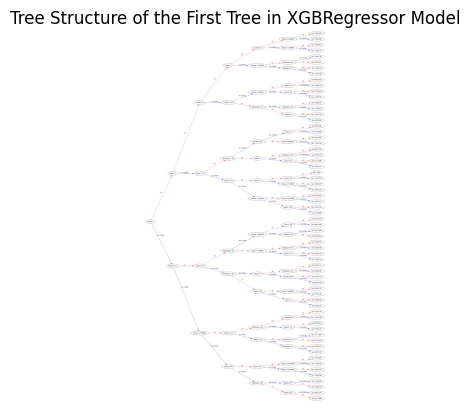

In [14]:
# Plot the structure of the first tree in the model
plt.figure(figsize=(20, 10))
xgb.plot_tree(my_model_3, num_trees=0, rankdir='LR')
plt.title("Tree Structure of the First Tree in XGBRegressor Model")
plt.show()

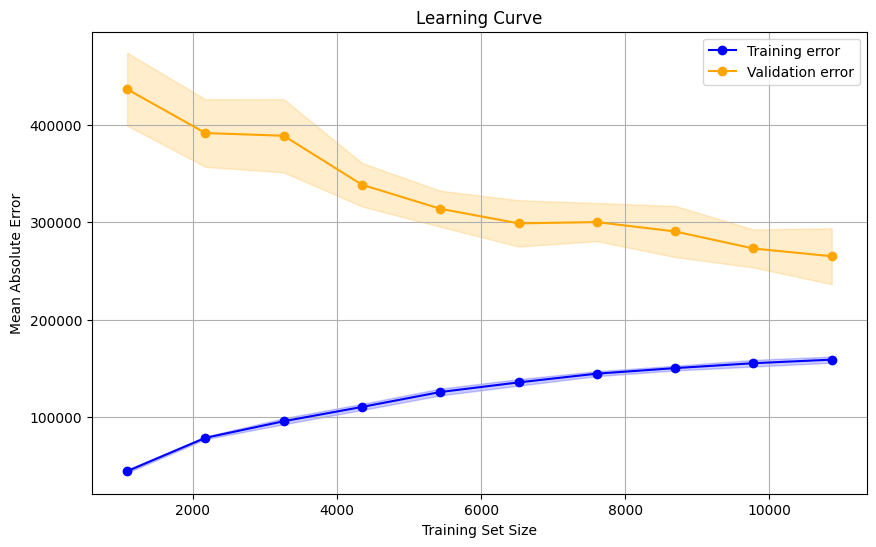

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy and alias it as np
from sklearn.model_selection import learning_curve

# Generate the learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    my_model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
    fit_params={'eval_set': [(X_valid, y_valid)]}  # Pass validation data here
)

# Calculate the mean and standard deviation for training and validation scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training error")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="blue")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="orange", label="Validation error")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2, color="orange")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Absolute Error")
plt.legend(loc="best")
plt.grid()
plt.show()

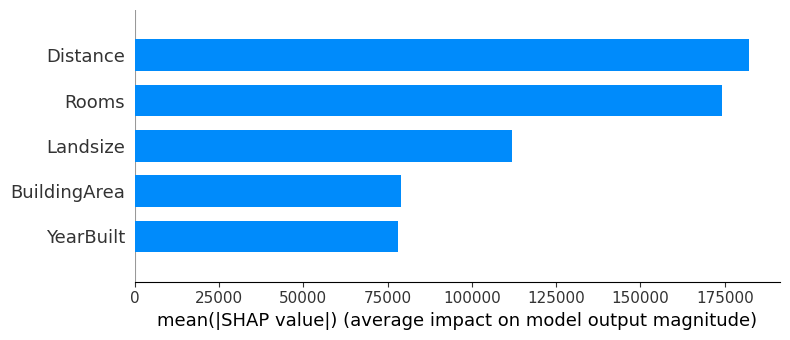

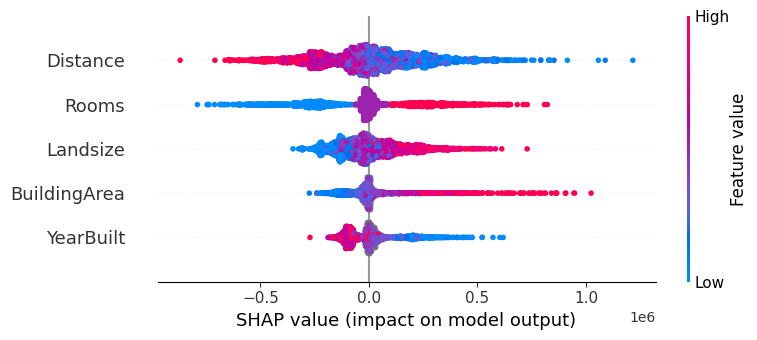

In [18]:
import shap

# Initialize the SHAP TreeExplainer
explainer = shap.TreeExplainer(my_model_3)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_valid)

# Plot SHAP summary plot (bar plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_valid, plot_type="bar")
plt.show()

# Plot SHAP summary plot (detailed distribution)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_valid)
plt.show()

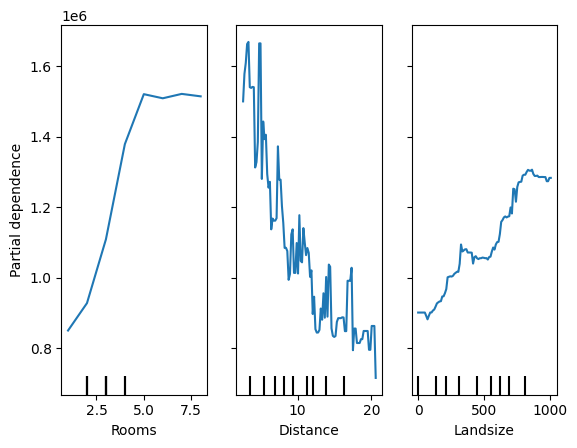

In [19]:
from sklearn.inspection import PartialDependenceDisplay

# Create the partial dependence plot
features = ['Rooms', 'Distance', 'Landsize']
PartialDependenceDisplay.from_estimator(my_model_3, X_valid, features)
plt.show()